# Kaggle Competition: Spaceship Titanic

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

#### Datasets:
- Train: Personal records for about 2/3 of passengers, to be used as training data
- Test: Personal records for the remaining 1/3 of the passengers, to be used as test data. The goal is to predict the value of 'Transported' in this set.

## Metadata

- **PassengerId (str)** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet (str)** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep (bool)** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin (str)** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination (str)** - The planet the passenger will be debarking to.
- **Age (float)** - The age of the passenger.
- **VIP (bool)** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (float)** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name (str)** - The first and last names of the passenger.
- **Transported (bool)** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
np.set_printoptions(legacy='1.25')

# Loading train set and data cleaning

In [2]:
# Loading dataset

train = pd.read_csv('train.csv')

# split Cabin to extract more information

train['Deck'] = train['Cabin'].str.split(pat='/', expand=True)[0]
train['Side'] = train['Cabin'].str.split(pat='/', expand=True)[2]

# assign dtypes for less memory usage

column_mapper = {
    'HomePlanet':'category',
    'CryoSleep':'bool',
    'Destination':'category',
    'VIP':'bool',
    'Transported':'int'
}

train = train.astype(column_mapper).drop('Cabin', axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   HomePlanet    8492 non-null   category
 2   CryoSleep     8693 non-null   bool    
 3   Destination   8511 non-null   category
 4   Age           8514 non-null   float64 
 5   VIP           8693 non-null   bool    
 6   RoomService   8512 non-null   float64 
 7   FoodCourt     8510 non-null   float64 
 8   ShoppingMall  8485 non-null   float64 
 9   Spa           8510 non-null   float64 
 10  VRDeck        8505 non-null   float64 
 11  Name          8493 non-null   object  
 12  Transported   8693 non-null   int64   
 13  Deck          8494 non-null   object  
 14  Side          8494 non-null   object  
dtypes: bool(2), category(2), float64(6), int64(1), object(4)
memory usage: 781.4+ KB


In [3]:
# Proportion of observations with positive y variable, is well represented, won't have this risk for biasing the model

train['Transported'].value_counts(normalize=True)

Transported
1    0.503624
0    0.496376
Name: proportion, dtype: float64

In [4]:
# Impute missing values with the mode for categorical columns
categorical_columns = ['HomePlanet', 'Deck', 'Side', 'Destination']
train[categorical_columns] = train[categorical_columns].fillna(train[categorical_columns].mode().iloc[0])

# Impute missing values with the mean for numerical columns
numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']
train[numerical_columns] = train[numerical_columns].fillna(train[numerical_columns].mean())

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   HomePlanet    8693 non-null   category
 2   CryoSleep     8693 non-null   bool    
 3   Destination   8693 non-null   category
 4   Age           8693 non-null   float64 
 5   VIP           8693 non-null   bool    
 6   RoomService   8693 non-null   float64 
 7   FoodCourt     8693 non-null   float64 
 8   ShoppingMall  8693 non-null   float64 
 9   Spa           8693 non-null   float64 
 10  VRDeck        8693 non-null   float64 
 11  Name          8493 non-null   object  
 12  Transported   8693 non-null   int64   
 13  Deck          8693 non-null   object  
 14  Side          8693 non-null   object  
dtypes: bool(2), category(2), float64(6), int64(1), object(4)
memory usage: 781.4+ KB


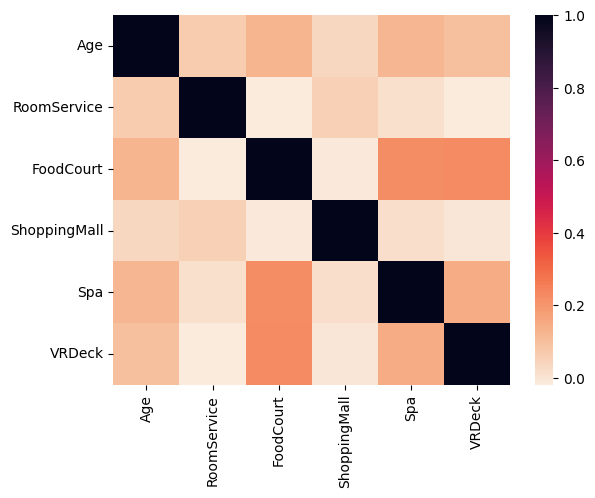

In [5]:
# Checking multicollinearity: not observable in continuous columns

df_continuous = train[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
df_continuous_corr = df_continuous.corr()

cmap = sns.cm.rocket_r
sns.heatmap(df_continuous_corr, cmap = cmap)
plt.show()

## Normalizing continuous data

**Normalization vs Standardization**

- Normalization (min-max): scales data to a range from 0 and 1
$$
X_{normal.} = \frac{X-X_{min}}{X_{max}-X_{min}}
$$
- Stardardization: transform data to have a mean ($\mu$) of 0 and standard dev ($\sigma$) of 1
$$
X_{stand.} = \frac{X-\mu}{\sigma}
$$
<br> As Logistic Regression assumes a normal distribution, I'll be using a Z-score standardization

In [6]:
continuous_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [7]:
# Z-Score normalize the continuous variables

standard_scaler = StandardScaler()

X_standard = standard_scaler.fit_transform(train[continuous_features])
X_standard

array([[ 0.70943692, -0.34058987, -0.28731404, -0.29081703, -0.27666342,
        -0.26902263],
       [-0.33671733, -0.1753636 , -0.28166908, -0.24896783,  0.2115053 ,
        -0.23019432],
       [ 2.03456565, -0.27540886,  1.95561575, -0.29081703,  5.69428913,
        -0.22578201],
       ...,
       [-0.1972301 , -0.34058987, -0.28731404,  2.84285059, -0.27577423,
        -0.26902263],
       [ 0.2212316 , -0.34058987,  0.37063712, -0.29081703,  0.03722284,
         2.58574044],
       [ 1.05815501, -0.14959437,  2.65308161, -0.29081703, -0.27666342,
        -0.25843309]])

From 8693 observations,  5577  are 0 for selected column


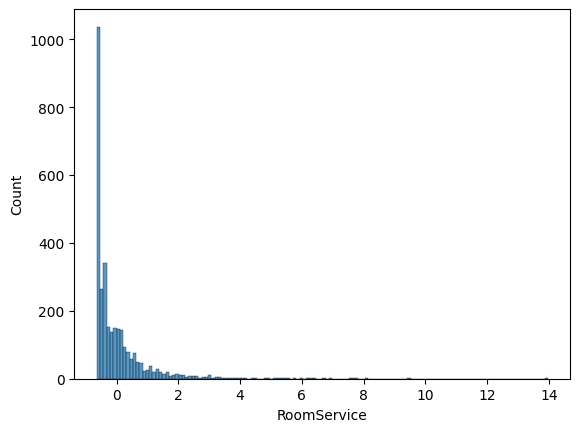

In [8]:
# input: column to check distribution
lookup_col = 'RoomService'

# calculation
df_cont_lookup = df_continuous[df_continuous[lookup_col] > 0]
lookup_standard = standard_scaler.fit_transform(df_cont_lookup)
cont_lookup = pd.DataFrame(lookup_standard, columns=continuous_features)

# output
not_zeros = X_standard.shape[0] - cont_lookup.shape[0]
print(f'From', X_standard.shape[0], 'observations, ', not_zeros, ' are 0 for selected column')
sns.histplot(data=cont_lookup, x=lookup_col);

In [9]:
# Convert transported to array to append
transported_arr = train['Transported'].to_numpy()
transported_arr = transported_arr[:, np.newaxis]

# Create df with normalized cont var and transported
X_yappended = np.append(X_standard, transported_arr, axis=1)
cont_standard = pd.DataFrame(X_yappended, columns= np.append(continuous_features, ['Transported'], axis=0))
cont_standard

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.709437,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0.0
1,-0.336717,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,1.0
2,2.034566,-0.275409,1.955616,-0.290817,5.694289,-0.225782,0.0
3,0.290975,-0.340590,0.517406,0.330225,2.683471,-0.098708,0.0
4,-0.894666,0.118709,-0.243409,-0.038048,0.225732,-0.267258,1.0
...,...,...,...,...,...,...,...
8688,0.848924,-0.340590,3.989682,-0.290817,1.184286,-0.203720,0.0
8689,-0.755179,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0.0
8690,-0.197230,-0.340590,-0.287314,2.842851,-0.275774,-0.269023,1.0
8691,0.221232,-0.340590,0.370637,-0.290817,0.037223,2.585740,0.0


## Treating categorical as dummies

In [10]:
train['CryoSleep'] = train.loc[:,'CryoSleep'].astype(int)
train['VIP'] = train.loc[:,'VIP'].astype(int)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   HomePlanet    8693 non-null   category
 2   CryoSleep     8693 non-null   int64   
 3   Destination   8693 non-null   category
 4   Age           8693 non-null   float64 
 5   VIP           8693 non-null   int64   
 6   RoomService   8693 non-null   float64 
 7   FoodCourt     8693 non-null   float64 
 8   ShoppingMall  8693 non-null   float64 
 9   Spa           8693 non-null   float64 
 10  VRDeck        8693 non-null   float64 
 11  Name          8493 non-null   object  
 12  Transported   8693 non-null   int64   
 13  Deck          8693 non-null   object  
 14  Side          8693 non-null   object  
dtypes: category(2), float64(6), int64(3), object(4)
memory usage: 900.2+ KB


In [11]:
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side']

In [12]:
# Using one hot encoding
# Using drop_first = True to avoid multicolinearity

df_categorical = train[np.append(categorical_features, ['CryoSleep', 'VIP'], axis=0)]
df_categorical_encoded = pd.get_dummies(df_categorical, columns = categorical_features, dtype='int', drop_first = True)
df_categorical_encoded

,CryoSleep,VIP,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,1,0,0,1
2,0,1,1,0,0,1,0,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,1,0,0,0,0,0,0,0,0,0,0,0
8689,1,0,0,0,1,0,0,0,0,0,0,1,0,1
8690,0,0,0,0,0,1,0,0,0,0,0,1,0,1
8691,0,0,1,0,0,0,0,0,0,1,0,0,0,1


#### Question

Should I use some technique to reduce the amount of parameters? Such as PCA? Or it should be done only when there are multicolinearity?
<br> I understand it has the trade-off of loosing interpretability

# Logistic Regression

## Overview

Consists of a Linear Regression, $y$ being the dependent variable and $x_n$ explanatory variables:
$$
y = \beta_0 + \beta_1 X_1 + ...+ \beta_n X_n
$$
Applied into a Sigmoid function:
$$
p = \frac{1}{1+e^{-y}}
$$

<br> Therefore, Logistic regression is similar to linear regression, except that coefficients are in terms of *log(odds)*.
<br> Additionally, to fit the line based on coefficients to observed datapoints, logistic regression uses *Maximum Likelihood Estimation (MLE)* instead of Least Squares Method.
<br> 
<br> Outcome will be a classification between 0 and 1 probability for the y-variable. Here it will be the "Transported" variable.


## Using skitlearn

### Only continuous features

In [13]:
X = cont_standard[continuous_features]
y = cont_standard['Transported']

# Splitting the dataframes into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=16) # randomization is part of this sklearn algorithm
print(f"{len(X_train)} examples in train the set and {len(X_valid)} examples in the validation set")

6519 examples in train the set and 2174 examples in the validation set


In [14]:
# Fitting the model to train sets and making the prediction on valiation

logreg = LogisticRegression(random_state=16)

classifier_cont = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

y_pred

array([1., 0., 1., ..., 0., 1., 0.])

In [15]:
#Comparing validation and predition for confustion matrix

cnf_matrix_1 = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix_1

array([[721, 371],
       [131, 951]])

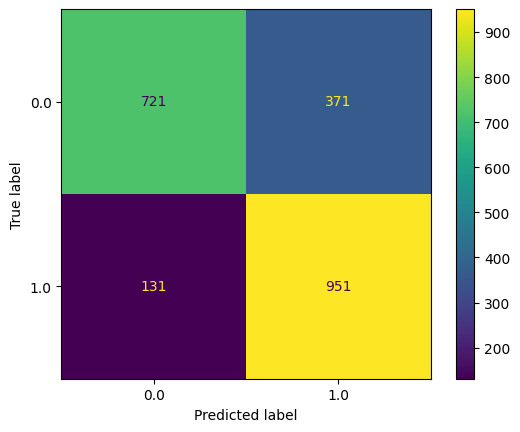

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier_cont, X_valid, y_valid);

In [17]:
# Detailing the Confusion Matrix results

print(f'True negatives: ', cnf_matrix_1[0][0])
print(f'False negatives: ', cnf_matrix_1[1][0])
print(f'True positive: ', cnf_matrix_1[1][1])
print(f'False positive: ', cnf_matrix_1[0][1])

True negatives:  721
False negatives:  131
True positive:  951
False positive:  371


In [18]:
# Measure of accuracy

from sklearn.metrics import accuracy_score
accuracy_norm = accuracy_score(y_valid, y_pred, normalize=True)
accuracy_count = accuracy_score(y_valid, y_pred, normalize=False)
print(f'Accuracy = ', round(accuracy_count), ' right predictions, ', round(accuracy_norm,2), ' score') 

Accuracy =  1672  right predictions,  0.77  score


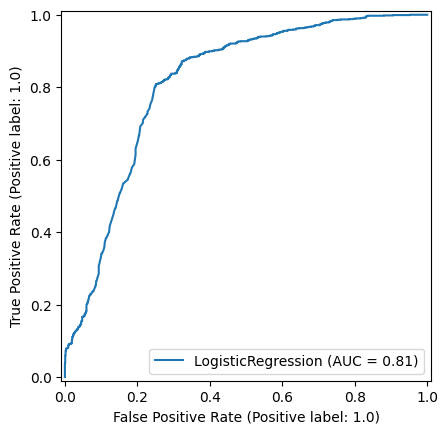

In [19]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(classifier_cont, X_valid, y_valid);

In [20]:
# Feture importance

classifier_cont_coeff_values = np.append(classifier_cont.coef_, np.exp(classifier_cont.coef_), axis=0)
classifier_cont_coeff = pd.DataFrame(classifier_cont_coeff_values, columns = continuous_features, index = ['Beta Coeff','Odds Ratio'])
classifier_cont_coeff

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Beta Coeff,0.054811,-1.523331,1.131891,0.120396,-2.634958,-2.322906
Odds Ratio,1.056341,0.217984,3.101515,1.127944,0.071722,0.097988


Beta Coeff:
- Positive Coefficient: increase in the predictor variable **increases** the log odds of the positive class.
- Negative Coefficient: increase in the predictor variable **decreases** the log odds of the positive class.
<br>
<br>
- Odds Ratio > 1: increases the odds of the outcome.
- Odds Ratio < 1: decreases the odds of the outcome.
- Odds Ratio = 1: does not affect the odds of the outcome.
<br>
<br> Important to have in mind that the continuous variables were standardized, so it shows relative importance.
<br> The test dataframe also needs to be standardized in order to use this model.

### Question:
Age has a small importance for the prediction. In econometry, you could do a Wald's test for the hypothesis that Beta Coeff of Age = 0 under 0.05 significance, if it is accepted you can remove this parameter. How would you treat this from a ML POV? That the weight of a given parameter is so small that it justifies being left out?

### Continuous and categorical features

In [21]:
append_cat_cont = np.append(df_categorical_encoded, cont_standard, axis=1)
full_df = pd.DataFrame(append_cat_cont, columns = np.append(df_categorical_encoded.columns, cont_standard.columns, axis=0))
full_df

,CryoSleep,VIP,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_G,Deck_T,Side_S,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.709437,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.336717,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,1.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.034566,-0.275409,1.955616,-0.290817,5.694289,-0.225782,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.290975,-0.340590,0.517406,0.330225,2.683471,-0.098708,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.894666,0.118709,-0.243409,-0.038048,0.225732,-0.267258,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.848924,-0.340590,3.989682,-0.290817,1.184286,-0.203720,0.0
8689,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-0.755179,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0.0
8690,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-0.197230,-0.340590,-0.287314,2.842851,-0.275774,-0.269023,1.0
8691,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.221232,-0.340590,0.370637,-0.290817,0.037223,2.585740,0.0


In [22]:
X = full_df.loc[:, ~full_df.columns.isin(['Transported'])]
y = full_df['Transported']

# Splitting the dataframes into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=16) # randomization is part of this sklearn algorithm
print(f"{len(X_train)} examples in train the set and {len(X_valid)} examples in the validation set")

6519 examples in train the set and 2174 examples in the validation set


In [23]:
# Fitting the model to train sets and making the prediction on validation

logreg = LogisticRegression(random_state=16)

classifier_complete = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

y_pred

array([1., 0., 0., ..., 0., 1., 1.])

In [24]:
#Comparing validation and predition for confustion matrix

cnf_matrix_2 = metrics.confusion_matrix(y_valid, y_pred)
cnf_matrix_2

array([[835, 257],
       [220, 862]])

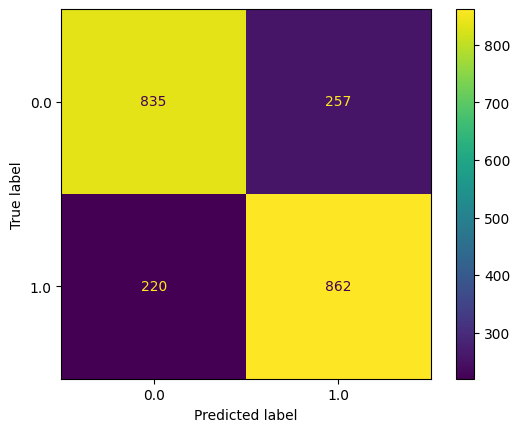

In [25]:
# Plotting the Confusion Matrix of model using all parameters (continuous and categorical)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier_complete, X_valid, y_valid);

In [26]:
# Measure of accuracy

from sklearn.metrics import accuracy_score
accuracy_norm = accuracy_score(y_valid, y_pred, normalize=True)
accuracy_count = accuracy_score(y_valid, y_pred, normalize=False)
print(f'Accuracy = ', round(accuracy_count), ' right predictions, ', round(accuracy_norm,2), ' score') 

Accuracy =  1697  right predictions,  0.78  score


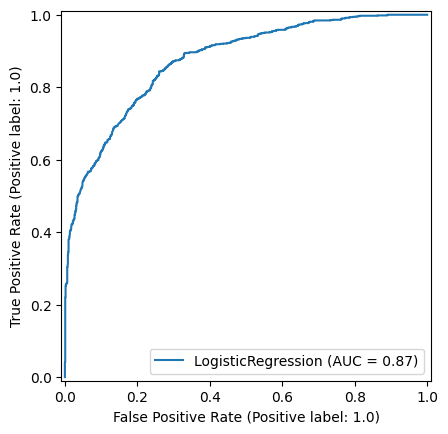

In [27]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(classifier_complete, X_valid, y_valid);

- **ROC:** A receiver operating characteristic, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate).
- **AUC:** area under the curve, translates the ROC curve into a single number. Probability that given a random positive and negative example. Will rank the positive higher than negative. A model with AUC = 1, will always classify a random passenger as transported

**Recall (TPR)**: proportion of all actual positives that were classified correctly as positives. Detection probability.
<br> Used when when false negatives cost more than false positives.
$$
TPR = \frac{TP}{TP+FN}
$$

In [28]:
# Model 1 (Only continuous) TPR/ Recall
recall_1 = cnf_matrix_1[1][1] / (cnf_matrix_1[1][1] + cnf_matrix_1[1][0])
print("Model 1 Recall = ",round(recall_1,3))

Model 1 Recall =  0.879


In [29]:
# Model 2 (Only continuous) TPR/ Recall
recall_2 = cnf_matrix_2[1][1] / (cnf_matrix_2[1][1] + cnf_matrix_2[1][0])
print("Model 2 Recall = ",round(recall_2,3))

Model 2 Recall =  0.797


### Question:
- What is the possible reason for the final accuracy being so similar, but distribution between types of errors so different (much more false negatives in this case)? This is cleary visible when comparing the two ROC curves as well
- Why the first model seems to have more cases of false positive, but the second model that has a higher AUC? Shouldn't be the opposite?
- In this case the false negative costs more (saying that a passenger wasn't teleported while it was, the outcome is that I won't look for him). So is it better to use the "Recall" metric to find the best model? Would the Model 1 be better, adding categorical didn't improve the model?
- How can I make an analysis of feature importance with so many different dummy variables? NUM_AS_ROOT was used in Random Forest

## Submission

<br> I was getting the error of features in fitting not matching, removing CabinNum solved.
<br> Apparently there were CabinNums present in test that are not present in train
<br> Why the random forest didn't have this error? Does TensorFlow cover this problem?

In [35]:
# Loading test dataset
test_df = pd.read_csv('test.csv')
submission_id = test_df['PassengerId']

# Impute missing values with the mode for categorical columns
categorical_columns = ['VIP', 'CryoSleep']
test_df[categorical_columns] = test_df[categorical_columns].fillna(test_df[categorical_columns].mode().iloc[0])

# Impute missing values with the mean for numerical columns
numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']
test_df[numerical_columns] = test_df[numerical_columns].fillna(test_df[numerical_columns].mean())

# Create new columns - Deck, and Side from the Cabin column, then drop Cabin.
## Not adding CabinNum as I was going thru error of Fit features not matching
test_df['Deck'] = test_df['Cabin'].str.split(pat='/', expand=True)[0]
test_df['Side'] = test_df['Cabin'].str.split(pat='/', expand=True)[2]
test_df = test_df.drop('Cabin', axis=1)

# Convert boolean columns (VIP, CryoSleep) to integers
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Remove PassengerId from features
X_submission = test_df.loc[:, ~test_df.columns.isin(['PassengerId'])]

# Standarization of continuous features
continuous_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X_submission[continuous_features])
cont_standard = pd.DataFrame(X_standard, columns= continuous_features)
cont_standard

# Hot encodding of categorical features
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side']
df_categorical = X_submission[np.append(categorical_features, ['CryoSleep', 'VIP'], axis=0)]
df_categorical_encoded = pd.get_dummies(df_categorical, columns = categorical_features, dtype='int', drop_first = True)
df_categorical_encoded

# Dataframe with full features
append_cat_cont = np.append(df_categorical_encoded, cont_standard, axis=1)
full_test_df = pd.DataFrame(append_cat_cont, columns = np.append(df_categorical_encoded.columns, cont_standard.columns, axis=0))
full_test_df

# Fitting the model to the classifier complete
classifier_complete = logreg.fit(X_train, y_train)

y_pred = logreg.predict(full_test_df).astype(bool)

output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': y_pred})
output

/tmp/ipykernel_5500/2477801520.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[categorical_columns] = test_df[categorical_columns].fillna(test_df[categorical_columns].mode().iloc[0])


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [36]:
sample_submission_df = pd.read_csv('sample_submission.csv')
sample_submission_df['Transported'] = y_pred
sample_submission_df.to_csv('submission_pietro.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


## Using Raw Python

Y-axis in logistic regression (between 0 and 1) is transformed from "probability of transported" to "log(odds of transported)", so it will be able to go from -infty to +infty
<br>In chart on the left, we can create a linear  with coefficients. It works the same, but in a scale of log(odds)
<br>.

<img src="../images/logistic_regression_continuous.png" alt="Continuous Regression" width="800"/>